# Protein Embedding Clusters Visualization

This notebook visualizes clusters in protein embeddings using dimensionality reduction techniques (UMAP and t-SNE).

Author: Hamed Heydari @ Vevo  
Date: April 01, 2025

In [46]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from umap import UMAP
import time
import random

# To create color map for the gene families
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

# Set better figure defaults
plt.rcParams['figure.figsize'] = (12, 10)
plt.style.use('ggplot')

plt.rcParams.update({
    'font.family': 'sans-serif',  # Using a generic sans-serif font that's available
    'font.sans-serif': ['DejaVu Sans', 'Helvetica', 'Liberation Sans', 'sans-serif'],
    'font.size': 12,
    'axes.linewidth': 1.5,
    'axes.edgecolor': 'black',
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'xtick.major.size': 5,
    'ytick.major.size': 5
})

## Load Protein Embeddings

We'll first load the embeddings from the HDF5 file and sample a subset for visualization.

In [47]:
# Path to the embeddings file
embedding_file = "../output/protein_embeddings_esmc_600m.h5"

# Load the embeddings
with h5py.File(embedding_file, "r") as f:
    # Get file metadata
    num_proteins = f.attrs.get('num_proteins', 0)
    model_name = f.attrs.get('embedding_model', 'unknown')
    embedding_dim = f.attrs.get('embedding_dimension', 0)
    
    print(f"Model: {model_name}")
    print(f"Total proteins: {num_proteins}")
    print(f"Embedding dimension: {embedding_dim}")
    
    # Load the full datasets
    all_embeddings = f["embeddings"][:]
    all_uniprot_ids = [id.decode('utf-8') for id in f["uniprot_ids"][:]]
    all_gene_names = [name.decode('utf-8') if name else "" for name in f["gene_names"][:]]
    
print(f"Loaded {len(all_embeddings)} embeddings with dimension {all_embeddings.shape[1]}")

Model: esmc_600m
Total proteins: 19329
Embedding dimension: 1152
Loaded 19329 embeddings with dimension 1152


## Sample Embeddings

For computational efficiency, we'll sample a subset of embeddings for visualization.

In [48]:
# Set sample size for visualization
SAMPLE_SIZE = len(all_embeddings) # This means full data. For quick checks, reduce it to 5K or less.

# Set random seed for reproducibility
random.seed(42)

# Sample without replacement if possible
if SAMPLE_SIZE <= len(all_embeddings):
    indices = random.sample(range(len(all_embeddings)), SAMPLE_SIZE)
else:
    indices = list(range(len(all_embeddings)))
    print(f"Warning: Requested sample size {SAMPLE_SIZE} exceeds available data {len(all_embeddings)}")
    SAMPLE_SIZE = len(all_embeddings)

# Extract the sampled data
embeddings = all_embeddings[indices]
uniprot_ids = [all_uniprot_ids[i] for i in indices]
gene_names = [all_gene_names[i] for i in indices]

print(f"Sampled {SAMPLE_SIZE} proteins for visualization")

Sampled 19329 proteins for visualization


## UMAP & tSNE Visualization

In [49]:
print("Running UMAP...")
start_time = time.time()

# Configure UMAP
umap_reducer = UMAP(
    n_components=2,          # Project to 2D for visualization
    n_neighbors=15,          # Number of neighbors to consider (local structure)
    min_dist=0.2,            # Minimum distance between points in the embedding
    metric='cosine',         # Use cosine distance for protein embeddings
)

# Fit and transform the embeddings
umap_result = umap_reducer.fit_transform(embeddings)

print(f"UMAP completed in {time.time() - start_time:.2f} seconds")

Running UMAP...


/vevo/micromamba/envs/esm-c/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP completed in 13.37 seconds


In [50]:
print("Running t-SNE...")
start_time = time.time()

# Configure t-SNE
tsne = TSNE(
    n_components=2,          # Project to 2D for visualization
    perplexity=30,           # Related to the number of nearest neighbors
    metric='cosine',         # Use cosine distance for protein embeddings
    random_state=42          # For reproducibility
)

# Fit and transform the embeddings
tsne_result = tsne.fit_transform(embeddings)

print(f"t-SNE completed in {time.time() - start_time:.2f} seconds")

Running t-SNE...
t-SNE completed in 29.66 seconds


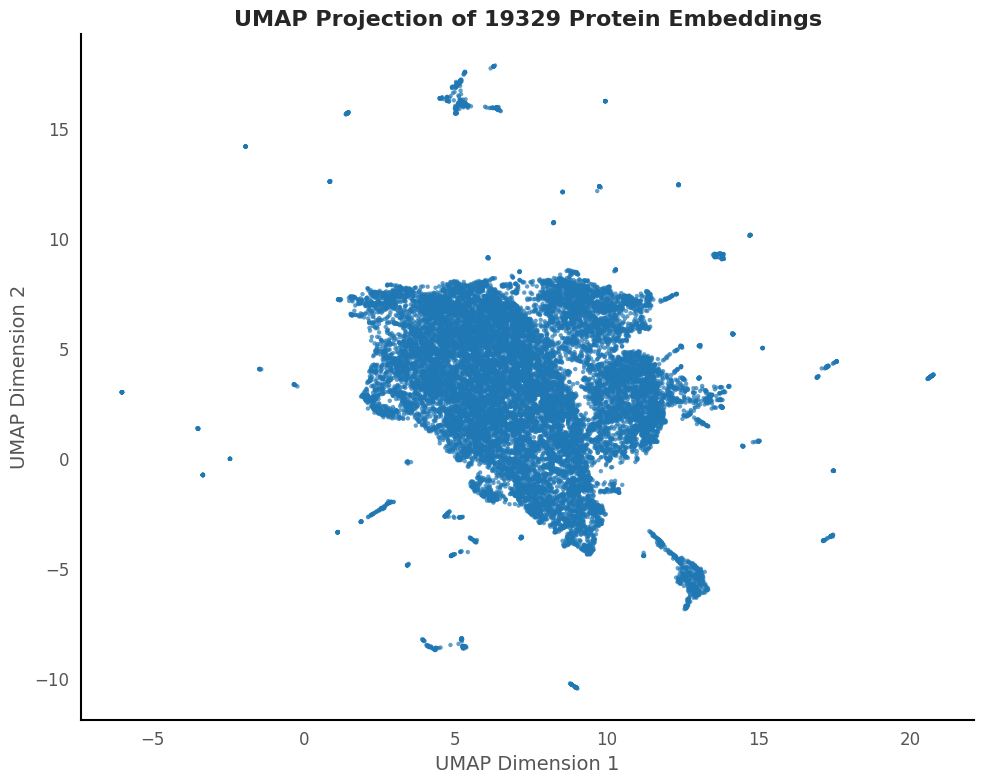

In [51]:
# Create DataFrame for plotting
umap_df = pd.DataFrame({
    'UMAP1': umap_result[:, 0],
    'UMAP2': umap_result[:, 1],
    'UniProt': uniprot_ids,
    'Gene': gene_names
})

fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
ax.set_facecolor('white')

scatter = ax.scatter(
    umap_df['UMAP1'], 
    umap_df['UMAP2'], 
    s=10,               
    alpha=0.7,         
    c='#1f77b4',        
    edgecolor='none'    
)

ax.set_title(f'UMAP Projection of {SAMPLE_SIZE} Protein Embeddings', fontsize=16, fontweight='bold')
ax.set_xlabel('UMAP Dimension 1', fontsize=14)
ax.set_ylabel('UMAP Dimension 2', fontsize=14)

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('../output/protein_embeddings_umap.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

## Analyze Specific Gene Groups

Let's check if genes with similar functions cluster together in the embedding space.

In [52]:
# Define some gene families for highlighting
gene_families = {
    'Hemoglobin': [g for g in gene_names if g.startswith('HB')],
    'Kinases': [g for g in gene_names if g.endswith('K') or 'KIN' in g or 'CDK' in g],
    'Histones': [g for g in gene_names if g.startswith('HIST')],
    'Collagen': [g for g in gene_names if g.startswith('COL')],
    'Zinc Finger': [g for g in gene_names if g.startswith('ZNF')]
}

# Print counts of genes found in each family
print("Genes found in defined families:")
for family, genes in gene_families.items():
    print(f"  {family}: {len(genes)} genes")
    if len(genes) > 0:
        print(f"    Examples: {', '.join(genes[:5])}")
        if len(genes) > 5:
            print(f"    ...and {len(genes) - 5} more")

Genes found in defined families:
  Hemoglobin: 12 genes
    Examples: HBA1; HBA2, HBS1L, HBEGF, HBM, HBB
    ...and 7 more
  Kinases: 182 genes
    Examples: CDKL4, AGK, CDK16, POGK, CDK19
    ...and 177 more
  Histones: 0 genes
  Collagen: 50 genes
    Examples: COL4A2, COLGALT1, COLGALT2, COL8A2, COL16A1
    ...and 45 more
  Zinc Finger: 508 genes
    Examples: ZNF706, ZNF804A, ZNF615, ZNF211, ZNF892
    ...and 503 more


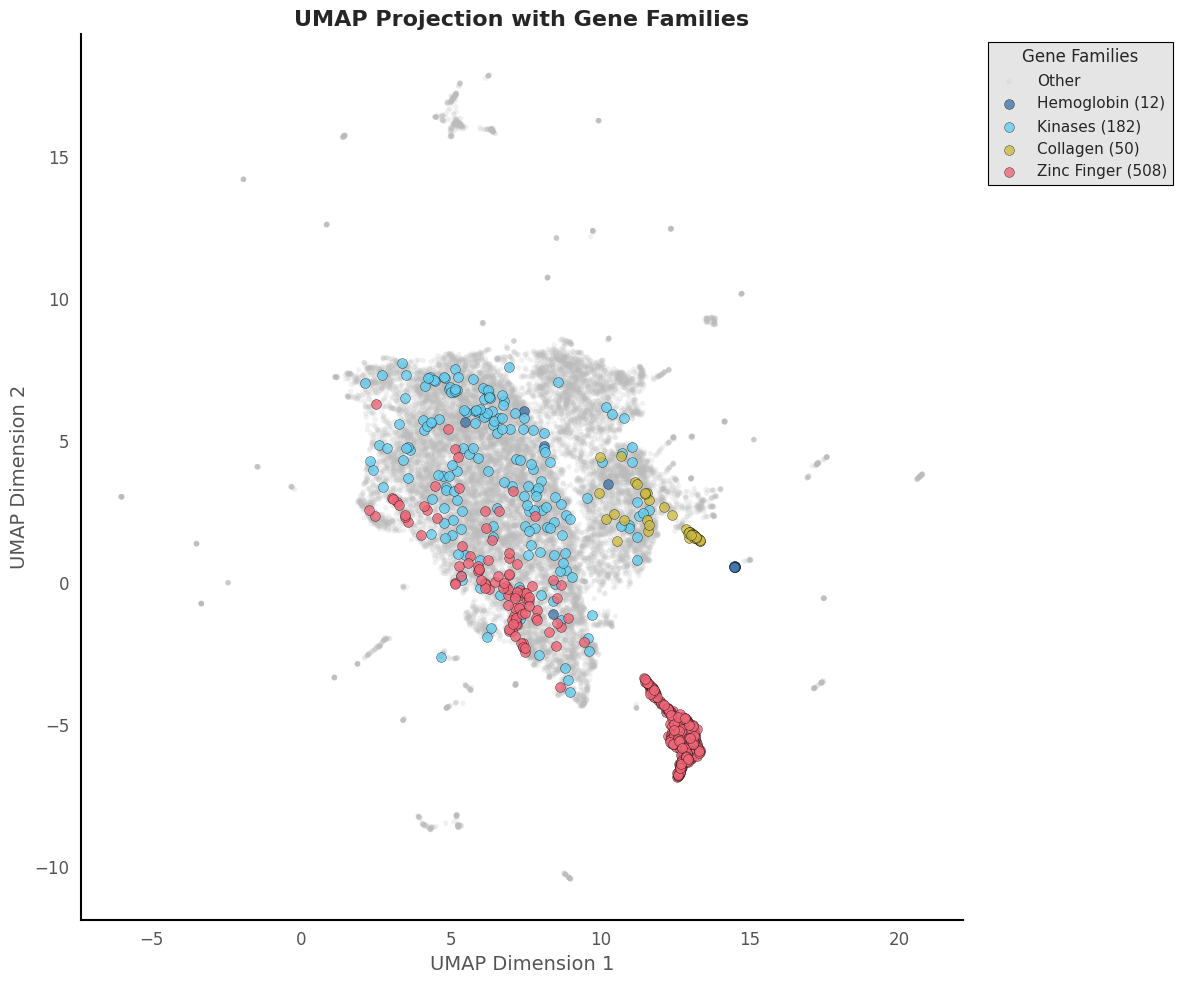

In [53]:
# Custom color palette
color_list = [
    '#4477AA', '#66CCEE', '#228833', 
    '#CCBB44', '#EE6677', '#AA3377', 
    '#BBBBBB', '#004488', '#DDAA33'
]
# Extend if more than 9 gene families
if len(gene_families) > 9:
    color_list.extend(plt.cm.tab20(range(len(gene_families) - 9)))

family_colors = {family: color_list[i % len(color_list)] for i, family in enumerate(gene_families.keys())}
family_colors['Other'] = '#BBBBBB'  # Gray for 'Other' category

# Assign families to genes
gene_to_family = {}
for family, genes in gene_families.items():
    for gene in genes:
        gene_to_family[gene] = family

# Create a list of families for each gene in our visualization
point_families = [gene_to_family.get(gene, 'Other') for gene in gene_names]

# Create figure with white background
fig, ax = plt.subplots(figsize=(12, 10), facecolor='white')
ax.set_facecolor('white')

# First plot all 'Other' points in the background
other_indices = [i for i, family in enumerate(point_families) if family == 'Other']
ax.scatter(
    umap_df['UMAP1'].iloc[other_indices],
    umap_df['UMAP2'].iloc[other_indices],
    s=15,
    alpha=0.2,  # More transparent
    color=family_colors['Other'],
    label='Other' if other_indices else None,  # Only add to legend if there are points
    edgecolor='none'
)

# Then plot each gene family with its own color
for family in gene_families.keys():
    family_indices = [i for i, f in enumerate(point_families) if f == family]
    if family_indices: 
        ax.scatter(
            umap_df['UMAP1'].iloc[family_indices],
            umap_df['UMAP2'].iloc[family_indices],
            s=50,  # Larger size for better visibility
            alpha=0.8,
            color=family_colors[family],
            label=f'{family} ({len(family_indices)})',
            edgecolor='k',
            linewidth=0.3
        )


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle='--', alpha=0.2)

ax.set_title('UMAP Projection with Gene Families', fontsize=16, fontweight='bold')
ax.set_xlabel('UMAP Dimension 1', fontsize=14)
ax.set_ylabel('UMAP Dimension 2', fontsize=14)

legend = ax.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    frameon=True,
    fancybox=False,
    framealpha=1,
    edgecolor='black',
    fontsize=11,
    title='Gene Families',
    title_fontsize=12
)
legend.get_frame().set_linewidth(0.8)

# Adjust layout and save with higher resolution
plt.tight_layout()
plt.savefig('../output/protein_embeddings_umap_families.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

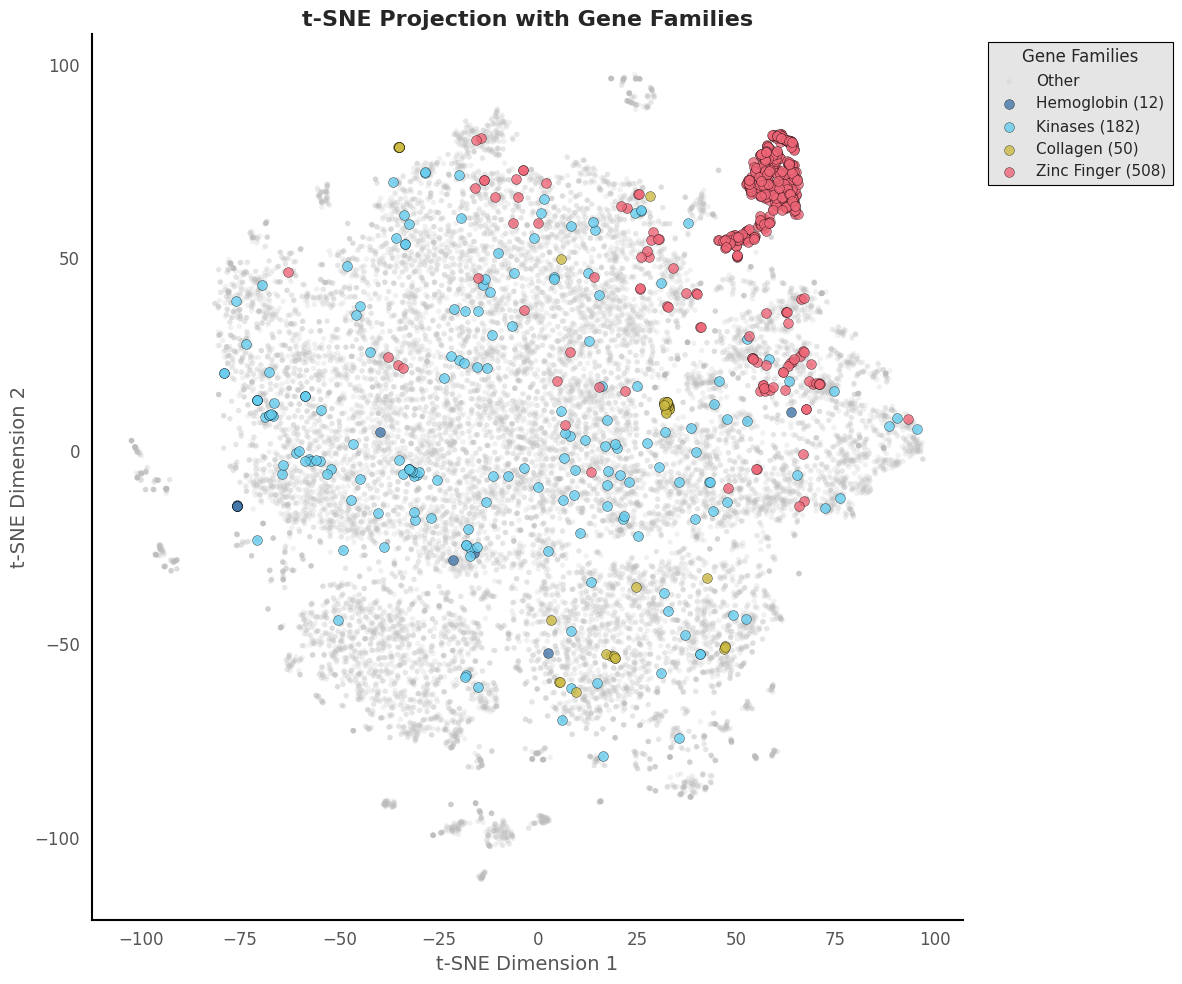

In [54]:
fig, ax = plt.subplots(figsize=(12, 10), facecolor='white')
ax.set_facecolor('white')

# First plot all 'Other' points in the background
other_indices = [i for i, family in enumerate(point_families) if family == 'Other']
ax.scatter(
    tsne_df['tSNE1'].iloc[other_indices],
    tsne_df['tSNE2'].iloc[other_indices],
    s=15,
    alpha=0.2,  # More transparent for better contrast
    color=family_colors['Other'],
    label='Other' if other_indices else None,  # Only add to legend if there are points
    edgecolor='none'
)

# Then plot each gene family with its own color
for family in gene_families.keys():
    family_indices = [i for i, f in enumerate(point_families) if f == family]
    if family_indices:
        ax.scatter(
            tsne_df['tSNE1'].iloc[family_indices],
            tsne_df['tSNE2'].iloc[family_indices],
            s=50,
            alpha=0.8,
            color=family_colors[family],
            label=f'{family} ({len(family_indices)})',
            edgecolor='k',
            linewidth=0.3
        )


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle='--', alpha=0.2)

ax.set_title('t-SNE Projection with Gene Families', fontsize=16, fontweight='bold')
ax.set_xlabel('t-SNE Dimension 1', fontsize=14)
ax.set_ylabel('t-SNE Dimension 2', fontsize=14)

legend = ax.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    frameon=True,
    fancybox=False,
    framealpha=1,
    edgecolor='black',
    fontsize=11,
    title='Gene Families',
    title_fontsize=12
)
legend.get_frame().set_linewidth(0.8)

# Adjust layout and save with higher resolution
plt.tight_layout()
plt.savefig('../output/protein_embeddings_tsne_families.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

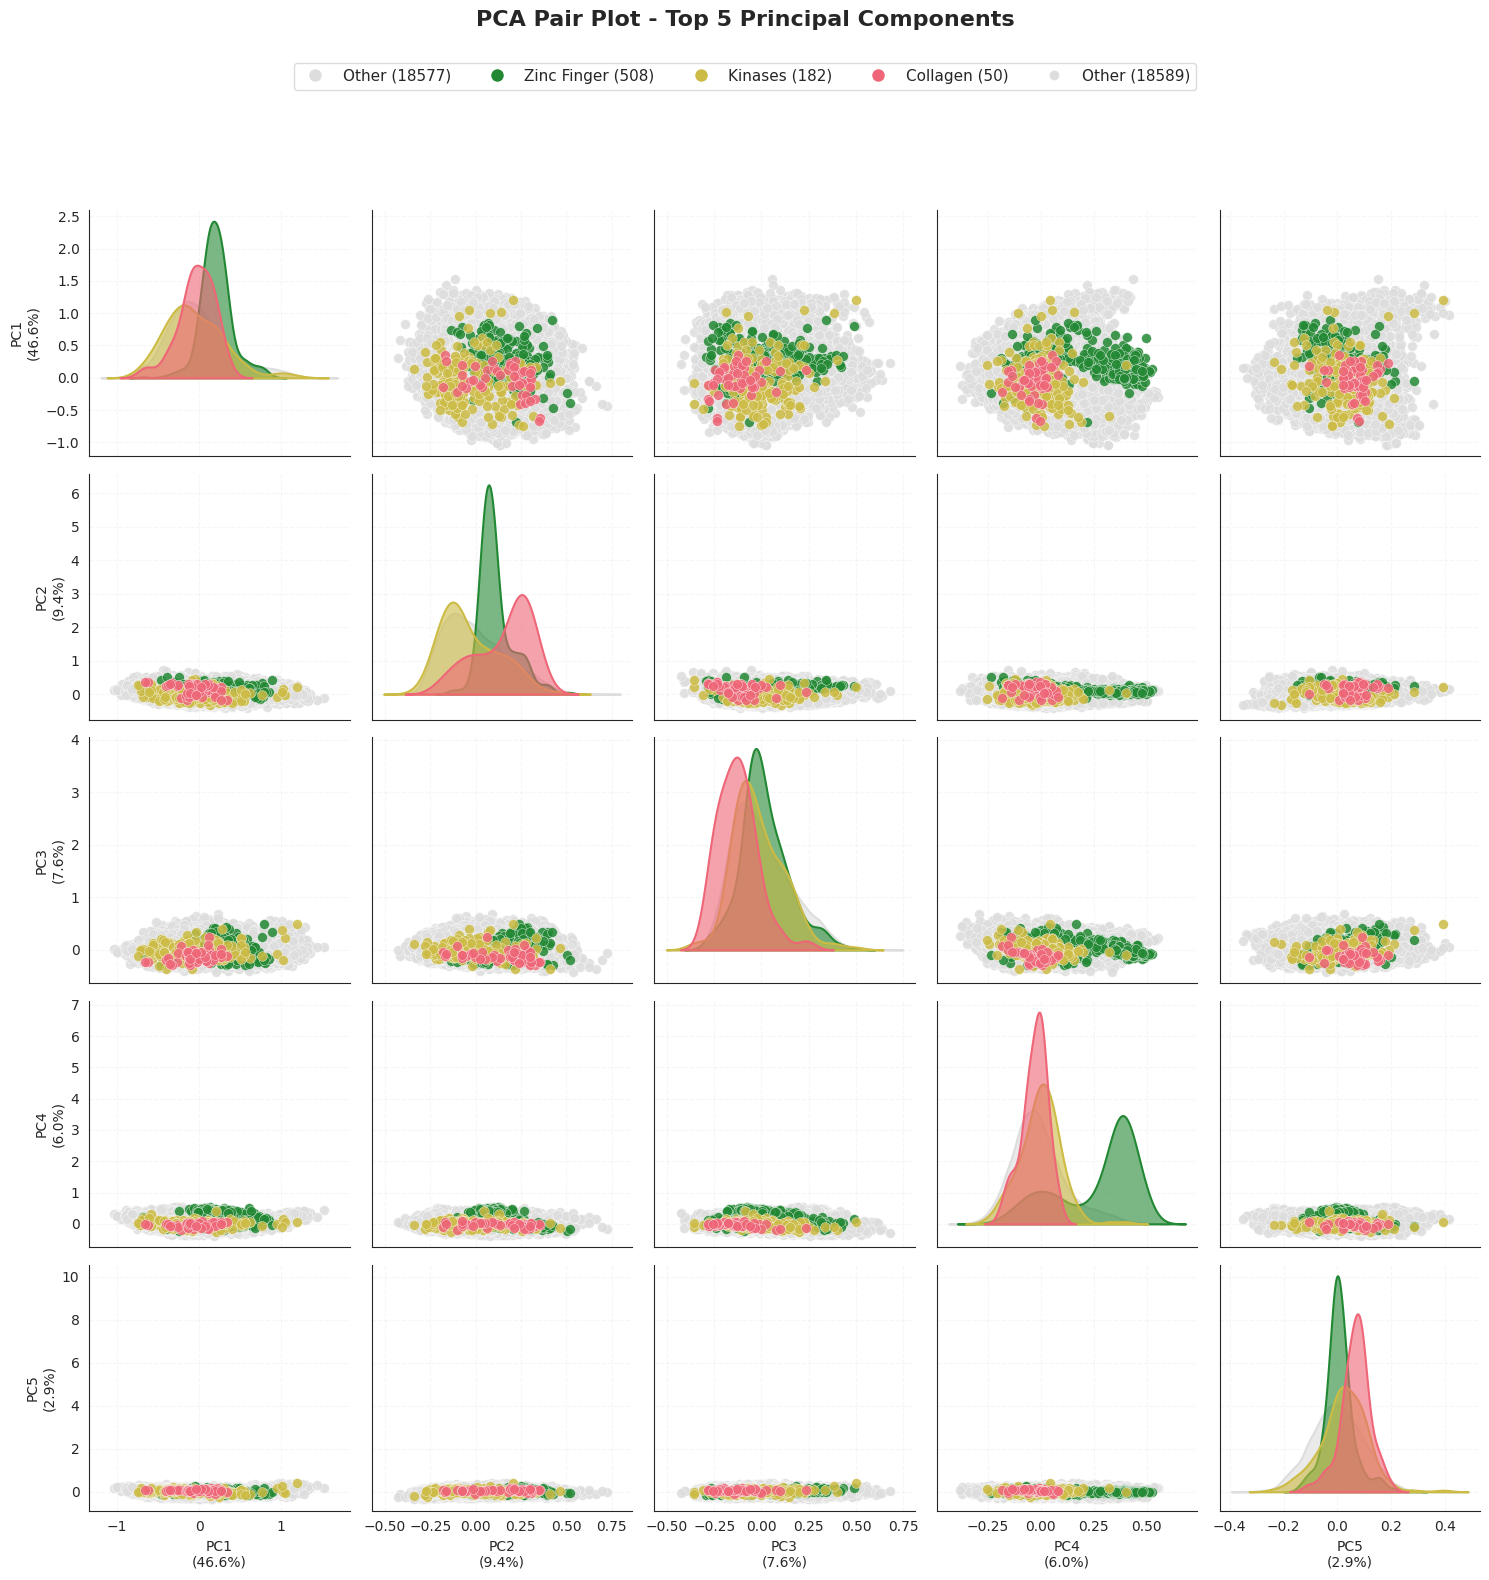

In [55]:
plt.style.use('default')
sns.set_style("white")

# Run PCA and prepare data
pca = PCA(n_components=5)
pca_result = pca.fit_transform(embeddings)
variance_explained = pca.explained_variance_ratio_

# Create DataFrame with PCA results
pc_vars = [f'PC{i+1}' for i in range(5)]
pca_df = pd.DataFrame(data=pca_result, columns=pc_vars)
pca_df['Gene'] = gene_names
pca_df['Family'] = family_labels

# Get top 4 families and mark others
family_counts = pd.Series(family_labels).value_counts()
top_families = family_counts.head(4).index.tolist()
pca_df['HighlightFamily'] = pca_df['Family'].apply(lambda x: x if x in top_families else 'Other')
other_mask = pca_df['HighlightFamily'] == 'Other'
other_count = other_mask.sum()

# Create pair grid
g = sns.PairGrid(pca_df, vars=pc_vars, hue='HighlightFamily', height=3, aspect=1, diag_sharey=False)

# Custom colors
palette = {
    top_families[0]: '#4477AA', top_families[1]: '#228833', 
    top_families[2]: '#CCBB44', top_families[3]: '#EE6677', 'Other': '#DDDDDD'
}

# Plot background points (Other category)
for i, ax in enumerate(g.axes.flat):
    if i < len(pc_vars)**2:
        row, col = i // len(pc_vars), i % len(pc_vars)
        if row != col:  # Off-diagonal plots
            # Plot Other points
            ax.scatter(
                pca_df[pc_vars[col]][other_mask], pca_df[pc_vars[row]][other_mask], 
                s=10, alpha=0.15, color=palette['Other'], label='_nolegend_'
            )
            # Clean up axes
            ax.grid(True, linestyle='--', alpha=0.2, color='lightgray')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
        else:  # Diagonal plots
            ax.grid(True, linestyle='--', alpha=0.2, color='lightgray')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

# Plot highlighted families
for family in top_families:
    family_mask = pca_df['HighlightFamily'] == family
    
    # Off-diagonal scatter plots
    for i, ax in enumerate(g.axes.flat):
        if i < len(pc_vars)**2:
            row, col = i // len(pc_vars), i % len(pc_vars)
            if row != col:
                ax.scatter(
                    pca_df[pc_vars[col]][family_mask], pca_df[pc_vars[row]][family_mask],
                    s=50, alpha=0.85, color=palette[family], edgecolor='white', linewidth=0.3
                )
            elif row == col:  # Diagonal KDE plots
                family_data = pca_df[pc_vars[row]][family_mask]
                sns.kdeplot(x=family_data, ax=ax, fill=True, alpha=0.6, linewidth=1.5, color=palette[family])

# Create legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[f], markersize=10, 
              label=f"{f} ({family_counts[f]})") for f in top_families
]
handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette['Other'], 
                         markersize=8, label=f"Other ({other_count})"))

# Add title, legend and labels
g.fig.legend(handles=handles, loc='upper center', ncol=len(top_families)+1, 
            fontsize=11, bbox_to_anchor=(0.5, 1.02), frameon=True, 
            facecolor='white', edgecolor='lightgray')
g.fig.suptitle('PCA Pair Plot - Top 5 Principal Components', y=1.05, fontsize=16, fontweight='bold')
g.fig.patch.set_facecolor('white')

# Add variance explained to axis labels
for i, ax in enumerate(g.axes.flat):
    if i < len(pc_vars)**2:
        row, col = i // len(pc_vars), i % len(pc_vars)
        ax.set_facecolor('white')
        if row == len(pc_vars)-1:  # Bottom row gets x-labels
            ax.set_xlabel(f"{pc_vars[col]}\n({variance_explained[col]*100:.1f}%)", fontsize=10)
        if col == 0:  # First column gets y-labels
            ax.set_ylabel(f"{pc_vars[row]}\n({variance_explained[row]*100:.1f}%)", fontsize=10)

# Save and display
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../output/protein_embeddings_pca_pairplot.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()